In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline  

In [2]:
import matplotlib.pyplot as plt
import numpy as np

from func2graph import models, tools, baselines, data

In [3]:
plt.rcParams.update({
    'axes.titlesize': 16,
    'axes.labelsize': 16,
    'xtick.labelsize': 16,
    'ytick.labelsize': 20,
})

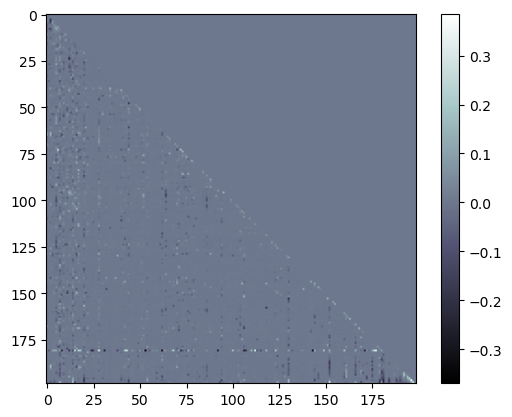

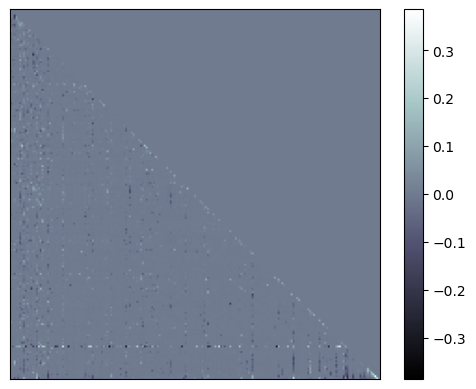

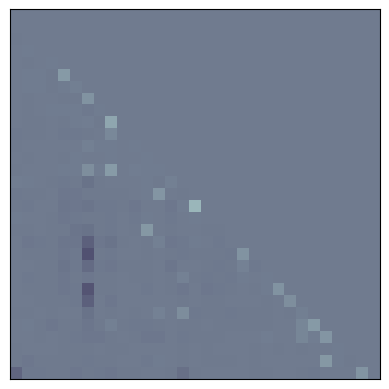

In [36]:
TT = np.load("./TT.npy")

plt.imshow(TT, cmap="bone")
plt.colorbar()
plt.show()

# make all elements except off-1 diagonal *0.85
for i in range(0, TT.shape[0]):
    for j in range(0, TT.shape[1]):
        if i != j+1:
            TT[i,j] = TT[i,j] * 0.9

abs_max = np.max(np.abs(TT))
vmin = -abs_max
vmax = abs_max
plt.imshow(TT, cmap="bone", vmin=vmin, vmax=vmax)
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.show()

plt.imshow(TT[80:111, 80:111], cmap='bone', vmin=vmin, vmax=vmax)
plt.xticks([])
plt.yticks([])
plt.show()

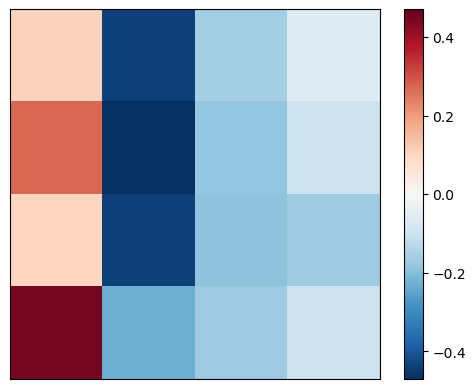

In [31]:
GT_prob_connectivity = np.load('..//data/Mouse_Local_Connectivity/GT_prob_connectivity.npy')
GT_strength_connectivity = np.load('..//data/Mouse_Local_Connectivity/GT_strength_connectivity.npy')

max_abs = np.max(np.abs(GT_strength_connectivity))
plt.imshow(GT_strength_connectivity, cmap='RdBu_r', interpolation='nearest', vmin=-max_abs, vmax=max_abs)
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.show()

### Plot cell-type activity at different states

In [4]:
directory = '../data/Mouse/Bugeon/'

input_sessions_file_path = [
    # {'date_exp': 'SB025/2019-10-04/', 'input_setting': 'Blank/01/'},
    # {'date_exp': 'SB025/2019-10-07/', 'input_setting': 'Blank/01/'},
    # {'date_exp': 'SB025/2019-10-08/', 'input_setting': 'Blank/01/'},
    # {'date_exp': 'SB025/2019-10-09/', 'input_setting': 'Blank/01/'},
    {'date_exp': 'SB025/2019-10-23/', 'input_setting': 'Blank/01/'},
    # {'date_exp': 'SB025/2019-10-24/', 'input_setting': 'Blank/01/'},
    # {'date_exp': 'SB026/2019-10-11/', 'input_setting': 'Blank/01/'},
    # {'date_exp': 'SB026/2019-10-14/', 'input_setting': 'Blank/01/'},
    # {'date_exp': 'SB026/2019-10-16/', 'input_setting': 'Blank/01/'},
    # {'date_exp': 'SB028/2019-11-06/', 'input_setting': 'Blank/01/'},
    # {'date_exp': 'SB028/2019-11-07/', 'input_setting': 'Blank/01/'},
    # {'date_exp': 'SB028/2019-11-08/', 'input_setting': 'Blank/01/'},
    # {'date_exp': 'SB028/2019-11-12/', 'input_setting': 'Blank/01/'},
    # {'date_exp': 'SB028/2019-11-13/', 'input_setting': 'Blank/01/'},
    # {'date_exp': 'SB030/2020-01-08/', 'input_setting': 'Blank/01/'},
    # {'date_exp': 'SB030/2020-01-10/', 'input_setting': 'Blank/01/'},
    # {'date_exp': 'SB030/2020-01-28/', 'input_setting': 'Blank/01/'},
]

normalization = "no"    #####################################

all_sessions_original_UniqueID = []
all_sessions_original_cell_type = []

all_sessions_acitvity = []
all_sessions_state = []

num_neurons_per_session = []
sessions_2_original_cell_type = []

for i in range(len(input_sessions_file_path)):
    date_exp = input_sessions_file_path[i]['date_exp']
    input_setting = input_sessions_file_path[i]['input_setting']

    activity, frame_states, frame_times, UniqueID, neuron_ttypes = data.load_mouse_data_session(
        directory, date_exp, input_setting, normalization
    )
    frame_states = frame_states.flatten()

    print('activity shape: ', activity.shape) 
    print('neuron_ttypes shape: ', len(neuron_ttypes))

    all_sessions_original_UniqueID.append(UniqueID)
    all_sessions_acitvity.append(activity)
    all_sessions_state.append(frame_states)
    num_neurons_per_session.append(activity.shape[0])

    # Get the first level of cell types
    neuron_types_result = []
    for j in range(len(neuron_ttypes)):
        # split by "-"
        neuron_types_result.append(neuron_ttypes[j].split("-")[0])

    sessions_2_original_cell_type.append(neuron_types_result)
    all_sessions_original_cell_type.append(neuron_types_result)
    print('neuron_types_result: ', neuron_types_result[:10])

    # Compute the number of neurons per cell type
    cell_type_count = {}
    for cell_type in neuron_types_result:
        if cell_type in cell_type_count:
            cell_type_count[cell_type] += 1
        else:
            cell_type_count[cell_type] = 1
    print('cell_type_count: ', cell_type_count)

all_sessions_original_UniqueID = np.concatenate(all_sessions_original_UniqueID)
all_sessions_original_cell_type = np.concatenate(all_sessions_original_cell_type)

print('all_sessions_acitvity: ', all_sessions_acitvity)
print('all_sessions_state: ', all_sessions_state)


##############################################
# Construct new UniqueID and cell type id
##############################################

all_sessions_new_UniqueID, num_unqiue_neurons = tools.assign_unique_neuron_ids(all_sessions_original_UniqueID, num_neurons_per_session)
all_sessions_new_cell_type_id, cell_type_order = tools.assign_unique_cell_type_ids(all_sessions_original_cell_type, num_neurons_per_session)

neuron_id_2_cell_type_id = np.zeros((num_unqiue_neurons,)).astype(int)
for i in range(len(all_sessions_new_UniqueID)):
    neuron_id_2_cell_type_id[all_sessions_new_UniqueID[i].astype(int)] = all_sessions_new_cell_type_id[i]

print('all_sessions_new_UniqueID: ', all_sessions_new_UniqueID)
print('all_sessions_new_cell_type_id: ', all_sessions_new_cell_type_id)
print('neuron_id_2_cell_type_id: ', neuron_id_2_cell_type_id)


no normalization
activity shape:  (527, 3943)
neuron_ttypes shape:  527
neuron_types_result:  ['EC', 'EC', 'EC', 'EC', 'EC', 'Lamp5', 'EC', 'EC', 'EC', 'EC']
cell_type_count:  {'EC': 264, 'Lamp5': 59, 'IN': 98, 'Vip': 49, 'Sst': 13, 'Sncg': 5, 'Pvalb': 38, 'Serpinf1': 1}
all_sessions_acitvity:  [array([[  0.       ,   0.       ,   0.       , ...,   0.       ,
          7.9225917,   0.       ],
       [ 68.06814  ,   0.       ,   0.       , ...,   1.7393335,
          0.       ,   0.       ],
       [389.54865  , 116.1313   ,  71.60391  , ...,   0.       ,
          0.       ,  57.60553  ],
       ...,
       [ 59.484024 ,  49.251095 , 105.86633  , ...,   0.       ,
         82.603    ,  48.50636  ],
       [ 17.11092  ,  33.916862 ,  60.901234 , ...,   0.       ,
         84.182976 ,   0.       ],
       [  0.       , 102.25694  , 143.83548  , ..., 128.97961  ,
         37.102867 ,  46.364532 ]], dtype=float32)]
all_sessions_state:  [array([0., 0., 0., ..., 0., 0., 0.])]
cell_type_orde

In [5]:
# Just look at the first session

activity = all_sessions_acitvity[0]
frame_states = all_sessions_state[0]
UniqueID = all_sessions_new_UniqueID[0]
cell_type_id = all_sessions_new_cell_type_id[0]

print('activity shape: ', activity.shape)
print('frame_states shape: ', frame_states.shape)
print('UniqueID shape: ', UniqueID.shape)
print('cell_type_id shape: ', cell_type_id.shape)

activity shape:  (527, 3943)
frame_states shape:  (3943,)
UniqueID shape:  (527,)
cell_type_id shape:  (527,)


In [6]:
# Group columns by state

activity_state0 = activity[:, frame_states == 0]
activity_state1 = activity[:, frame_states == 1]
activity_state2 = activity[:, frame_states == 2]

print(activity_state0.shape, activity_state1.shape, activity_state2.shape)

# Make them have the same number of columns
# min_steps = min(activity_state0.shape[1], activity_state1.shape[1], activity_state2.shape[1])
min_steps = 300

activity_state0 = activity_state0[:, :min_steps]
activity_state1 = activity_state1[:, :min_steps]
activity_state2 = activity_state2[:, :min_steps]

print(activity_state0.shape, activity_state1.shape, activity_state2.shape)

(527, 1311) (527, 1750) (527, 882)
(527, 300) (527, 300) (527, 300)


In [7]:
state0_activity = activity_state0
state1_activity = activity_state1
state2_activity = activity_state2

# Reorder the rows of the activity matrix, by cell type
state0_activity_type0 = state0_activity[neuron_id_2_cell_type_id == 0]
state0_activity_type1 = state0_activity[neuron_id_2_cell_type_id == 1]
state0_activity_type2 = state0_activity[neuron_id_2_cell_type_id == 2]
state0_activity_type3 = state0_activity[neuron_id_2_cell_type_id == 3]

print(state0_activity_type0.shape, state0_activity_type1.shape, state0_activity_type2.shape, state0_activity_type3.shape)

state1_activity_type0 = state1_activity[neuron_id_2_cell_type_id == 0]
state1_activity_type1 = state1_activity[neuron_id_2_cell_type_id == 1]
state1_activity_type2 = state1_activity[neuron_id_2_cell_type_id == 2]
state1_activity_type3 = state1_activity[neuron_id_2_cell_type_id == 3]

print(state1_activity_type0.shape, state1_activity_type1.shape, state1_activity_type2.shape, state1_activity_type3.shape)

state2_activity_type0 = state2_activity[neuron_id_2_cell_type_id == 0]
state2_activity_type1 = state2_activity[neuron_id_2_cell_type_id == 1]
state2_activity_type2 = state2_activity[neuron_id_2_cell_type_id == 2]
state2_activity_type3 = state2_activity[neuron_id_2_cell_type_id == 3]

print(state2_activity_type0.shape, state2_activity_type1.shape, state2_activity_type2.shape, state2_activity_type3.shape)

(264, 300) (98, 300) (59, 300) (38, 300)
(264, 300) (98, 300) (59, 300) (38, 300)
(264, 300) (98, 300) (59, 300) (38, 300)


In [8]:
# Subsample rows in each cell type to be the same

min_rows = min(state0_activity_type0.shape[0], state0_activity_type1.shape[0], state0_activity_type2.shape[0], state0_activity_type3.shape[0])

state0_activity_type0 = state0_activity_type0[:min_rows]
state0_activity_type1 = state0_activity_type1[:min_rows]
state0_activity_type2 = state0_activity_type2[:min_rows]
state0_activity_type3 = state0_activity_type3[:min_rows]

state1_activity_type0 = state1_activity_type0[:min_rows]
state1_activity_type1 = state1_activity_type1[:min_rows]
state1_activity_type2 = state1_activity_type2[:min_rows]
state1_activity_type3 = state1_activity_type3[:min_rows]

state2_activity_type0 = state2_activity_type0[:min_rows]
state2_activity_type1 = state2_activity_type1[:min_rows]
state2_activity_type2 = state2_activity_type2[:min_rows]
state2_activity_type3 = state2_activity_type3[:min_rows]

In [9]:
from matplotlib.colors import LinearSegmentedColormap
colors = {
    'EC': '#FFBF00',       # Yellow
    'Pvalb': '#8BC34A',    # Green
    'Sst': '#3F51B5',      # Blue
    'Vip': '#E91E63'       # Pink/Purple
}

# Create custom colormaps for each color (signal color to white background)
cmap_ec = LinearSegmentedColormap.from_list('ec_cmap', ['white', colors['EC'], 'black'])
cmap_pvalb = LinearSegmentedColormap.from_list('pvalb_cmap', ['white', colors['Pvalb'], 'black'])
cmap_sst = LinearSegmentedColormap.from_list('sst_cmap', ['white', colors['Sst'], 'black'])
cmap_vip = LinearSegmentedColormap.from_list('vip_cmap', ['white', colors['Vip'], 'black'])

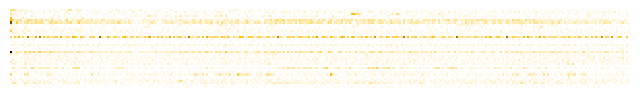

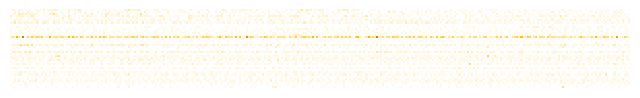

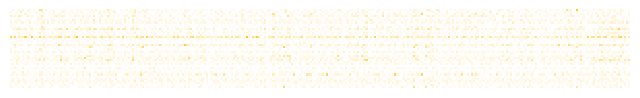

In [10]:
vmin = min(matrix.min() for matrix in [state0_activity_type0, state1_activity_type0, state2_activity_type0])
vmax = max(matrix.max() for matrix in [state0_activity_type0, state1_activity_type0, state2_activity_type0])

plt.figure(figsize=(8, 8))
plt.imshow(state0_activity_type0, cmap=cmap_ec, vmin=vmin, vmax=vmax, interpolation='nearest')
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

plt.figure(figsize=(8, 8))
plt.imshow(state1_activity_type0, cmap=cmap_ec, vmin=vmin, vmax=vmax, interpolation='nearest')
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

plt.figure(figsize=(8, 8))
plt.imshow(state2_activity_type0, cmap=cmap_ec, vmin=vmin, vmax=vmax, interpolation='nearest')
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

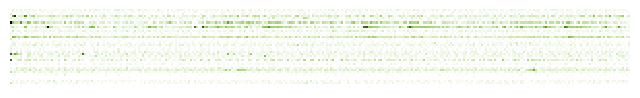

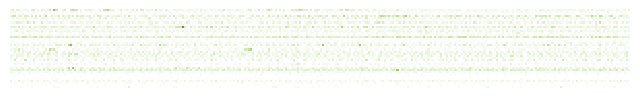

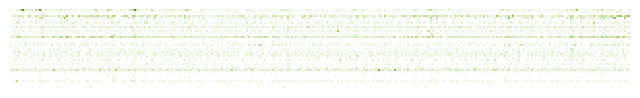

In [14]:
vmin = min(matrix.min() for matrix in [state0_activity_type1, state1_activity_type1, state2_activity_type1])
vmax = max(matrix.max() for matrix in [state0_activity_type1, state1_activity_type1, state2_activity_type1])

plt.figure(figsize=(8, 8))
plt.imshow(state0_activity_type1, cmap=cmap_pvalb, vmin=vmin, vmax=vmax, interpolation='nearest')
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

plt.figure(figsize=(8, 8))
plt.imshow(state1_activity_type1, cmap=cmap_pvalb, vmin=vmin, vmax=vmax, interpolation='nearest')
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

plt.figure(figsize=(8, 8))
plt.imshow(state2_activity_type1, cmap=cmap_pvalb, vmin=vmin, vmax=vmax, interpolation='nearest')
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

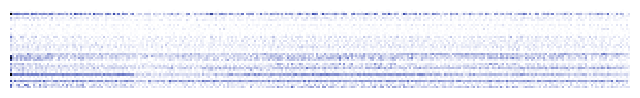

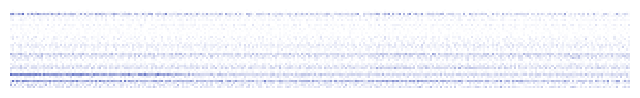

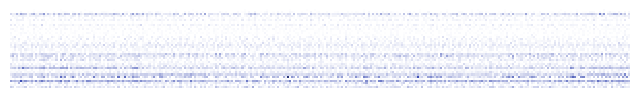

In [15]:
vmin = min(matrix.min() for matrix in [state0_activity_type2, state1_activity_type2, state2_activity_type2])
vmax = max(matrix.max() for matrix in [state0_activity_type2, state1_activity_type2, state2_activity_type2])

plt.figure(figsize=(8, 8))
plt.imshow(state0_activity_type2, cmap=cmap_sst, vmin=vmin, vmax=vmax, interpolation='nearest')
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

plt.figure(figsize=(8, 8))
plt.imshow(state1_activity_type2, cmap=cmap_sst, vmin=vmin, vmax=vmax, interpolation='nearest')
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

plt.figure(figsize=(8, 8))
plt.imshow(state2_activity_type2, cmap=cmap_sst, vmin=vmin, vmax=vmax, interpolation='nearest')
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

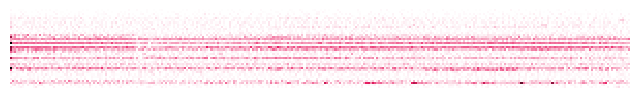

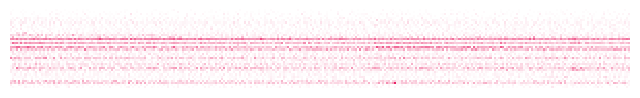

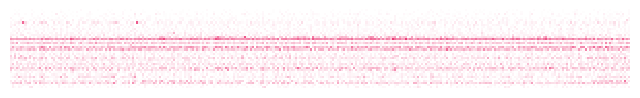

In [13]:
vmin = min(matrix.min() for matrix in [state0_activity_type3, state1_activity_type3, state2_activity_type3])
vmax = max(matrix.max() for matrix in [state0_activity_type3, state1_activity_type3, state2_activity_type3])

plt.figure(figsize=(8, 8))
plt.imshow(state0_activity_type3, cmap=cmap_vip, vmin=vmin, vmax=vmax, interpolation='nearest')
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

plt.figure(figsize=(8, 8))
plt.imshow(state1_activity_type3, cmap=cmap_vip, vmin=vmin, vmax=vmax, interpolation='nearest')
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

plt.figure(figsize=(8, 8))
plt.imshow(state2_activity_type3, cmap=cmap_vip, vmin=vmin, vmax=vmax, interpolation='nearest')
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

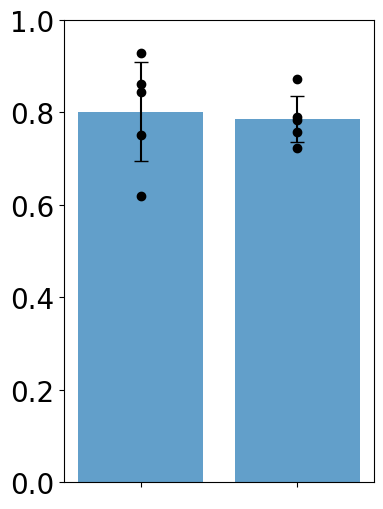

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Data for the bar plot with Spearman values
single_session_spearman = [0.861, 0.929, 0.845, 0.752, 0.620]
multi_session_spearman = [0.791, 0.758, 0.722, 0.783, 0.873]

# Calculate mean and standard deviation for error bars
spearman_means = [np.mean(single_session_spearman), np.mean(multi_session_spearman)]
spearman_std_devs = [np.std(single_session_spearman), np.std(multi_session_spearman)]

# Categories for the plot
categories_spearman = ['Single-session', 'Multi-session']

# Create the bar plot with error bars
fig, ax = plt.subplots()
# change figure size
fig.set_size_inches(4, 6)
bars = ax.bar(categories_spearman, spearman_means, yerr=spearman_std_devs, capsize=5, alpha=0.7)
ax.set_ylim(0, 1)

# Add individual data points for single-session and multi-session
x_single = np.random.normal(0, 0, size=len(single_session_spearman)) + 0  # jitter for single-session
x_multi = np.random.normal(1, 0, size=len(multi_session_spearman)) + 0  # jitter for multi-session
ax.plot(x_single, single_session_spearman, 'o', color='black', label='Single-session Data Points')
ax.plot(x_multi, multi_session_spearman, 'o', color='black', label='Multi-session Data Points')

# Add labels and title
# ax.set_ylabel('Mean Spearman Value')
# ax.set_title('Single-session vs Multisession Spearman Correlation')

# set x-axis tick labels
ax.set_xticklabels([])

# Display the plot
plt.show()

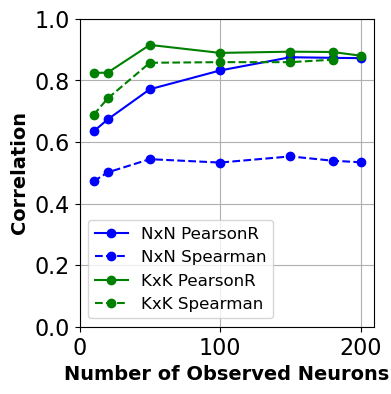

In [32]:
import matplotlib.pyplot as plt

# X and Y values for all lines
x = [10, 20, 50, 100, 150, 180, 200]
y1_new = [0.634, 0.673, 0.771, 0.832, 0.875, 0.873, 0.872]
y2_new = [0.472, 0.501, 0.544, 0.533, 0.553, 0.539, 0.534]
y3_new = [0.824, 0.825, 0.915, 0.889, 0.893, 0.892, 0.880]
x4 = [10, 20, 50, 100, 150, 180]
y4_new = [0.688, 0.741, 0.857, 0.859, 0.859, 0.867]

plt.figure(figsize=(3.8, 4))  # Increased width while maintaining height
# Updated first line
plt.plot(x, y1_new, marker='o', label='NxN PearsonR', color='blue')
# Updated second line, same color but dashed
plt.plot(x, y2_new, marker='o', linestyle='--', label='NxN Spearman', color='blue')
# Updated third line, different color and solid line
plt.plot(x, y3_new, marker='o', label='KxK PearsonR', color='green')
# Updated fourth line, same color as third but dashed and updated legend
plt.plot(x4, y4_new, marker='o', linestyle='--', label='KxK Spearman', color='green')
plt.xlabel('Number of Observed Neurons', fontsize=14, fontweight='bold')  # Swapped label
plt.ylabel('Correlation', fontsize=14, fontweight='bold')  # Swapped label
# plt.title('Partial Observation on Simulation', fontsize=16, fontweight='bold')
plt.grid(True)
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)
plt.xlim(left=0)
plt.ylim(0, 1)
plt.legend(fontsize=12)
plt.show()
